#  Predicting Student GPA Using Linear Regression

We aim to predict a student's GPA based on their weekly study time. We'll use a **linear regression model**, which we've already studied in class as part of **supervised machine learning**.

We are using **two datasets**:
- A real-world dataset from OpenML
- A simulated dataset from Kaggle

###  Why use Linear Regression?

We chose linear regression because:

- It is **simple and interpretable**, making it ideal for identifying basic relationships between variables.
- It helps us **quantify the strength and direction** of the relationship between study time and GPA.
- We already know how it works — it was covered in class under **regression analysis**, including concepts like the regression line, R² score, and prediction error.
- It’s a good **baseline model**: if linear regression performs well, more complex models may not be needed.


### Focus

The **data cleaning and preparation** was already done in Part 1 of the project. We saved the cleaned dataset into the `../Data/CleanedData/` folder an therefor we will not be cleaning anything agian.

This step is about 
- Exploratory analysis (EDA)
- Feature selection and model training
- Evaluation and visualization of the results

## Step 1: Load the Cleaned Dataset
Now that the data has been cleaned and saved in Part 1, we load it from the `../Data/CleanedData/` folder.

We'll take an initial look at the structure, data types, and a few example rows to confirm it's ready for modeling.
But befor we do all that, we have to import all the necessary libraries

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


# Set visual style
sns.set(style="whitegrid")

We load the datasets can take a look

In [187]:

# Load datasets 
real_df = pd.read_csv("../Data/CleanedData/real_data_cleaned.csv")
sim_df = pd.read_csv("../Data/CleanedData/simulated_data_cleaned.csv")

print("Real Data:")
display(real_df.head())

print("Simulated Data:")
display(sim_df.head())

Real Data:


,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,17.0,1.0,0.0,2.0,19.833723,7.0,NaN,NaN,NaN,NaN,NaN,NaN,2.929196,2.0
1,18.0,0.0,0.0,1.0,15.408756,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.042915,1.0
2,15.0,0.0,2.0,3.0,4.210570,26.0,NaN,NaN,NaN,NaN,NaN,NaN,0.112602,4.0
3,17.0,1.0,0.0,3.0,10.028829,14.0,NaN,NaN,NaN,NaN,NaN,NaN,2.054218,3.0
4,17.0,1.0,0.0,2.0,4.672495,17.0,NaN,NaN,NaN,NaN,NaN,NaN,1.288061,4.0


Simulated Data:


,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,s1000,23,female,0.0,1.2,1.1,no,85.0,8.0,fair,6,master,average,8,yes,56.2
1,s1001,20,female,6.9,2.8,2.3,no,97.3,4.6,good,6,high school,average,8,no,100.0
2,s1002,21,male,1.4,3.1,1.3,no,94.8,8.0,poor,1,high school,poor,1,no,34.3
3,s1003,23,female,1.0,3.9,1.0,no,71.0,9.2,poor,4,master,good,1,yes,26.8
4,s1004,19,female,5.0,4.4,0.5,no,90.9,4.9,fair,3,master,good,1,no,66.4


##  Step 2: Align the two datasets

Before we can combine or compare the datasets, we need to make sure they share the same structure and column names.

In this case:
- `study_hours_per_day` (simulated) must be converted to weekly study time
- `exam_score` will be treated as GPA (with a note that it's not the exact same measure)


In [188]:
# Convert daily study hours to weekly (assuming 5 study days)
sim_df["StudyTimeWeekly"] = sim_df["study_hours_per_day"] * 5

# Rename exam_score to GPA for consistency
sim_df["GPA"] = sim_df["exam_score"]

### Select relevant columns only
After renaming, we remove all columns we don't need.
We keep only the features required for the model: `StudyTimeWeekly` and `GPA`.

In [189]:
real_model_df = real_df[["StudyTimeWeekly", "GPA"]]
sim_model_df = sim_df[["StudyTimeWeekly", "GPA"]]

## Step 3: Combine Both Datasets
Now we merge both datasets into one combined dataset for training and testing.
Then we preview the result to ensure everything looks as expected.

In [190]:
combined_df = pd.concat([real_model_df, sim_model_df], ignore_index=True)
combined_df.head()

,StudyTimeWeekly,GPA
0,19.833723,2.929196
1,15.408756,3.042915
2,4.210570,0.112602
3,10.028829,2.054218
4,4.672495,1.288061


## Step 4: Explore the Data (EDA)

Before training the model, we explore the combined dataset to understand how study time relates to GPA.

We'll check:
- Summary statistics
- Distribution of GPA and study time
- Visual correlation between study time and GPA


In [191]:
# Summary statistics
combined_df.describe()

,StudyTimeWeekly,GPA
count,3301.000000,3301.000000
mean,11.953379,20.535595
std,7.108897,31.511992
min,0.000000,0.000000
25%,6.345104,1.469389
50%,11.702433,2.454307
75%,16.975352,45.700000
max,41.500000,100.000000


### ⚠️ Important Insight
Our code just gav an important insight 
the GPA column now contains mixed scales:

- The real dataset had GPA values like 2.9, 3.0, etc.
- The simulated dataset had exam_score values like 56.2, 100.0, etc.

So the model is now trying to predict a mix of different types of grades — which could distort the results.

### How do we know just by runing **.describe**  ? 

The max value was 100
→ A normal GPA never goes up to 100. That looks like a test score, not a GPA (which usually goes to 4).

The median (50%) was around 2.45
→ That looks like a GPA — so now I know we have both types in the same column.

The standard deviation was huge (31.5)
→ That means the numbers are spread really far apart — which only happens if two very different scales are mixed.

### How do we fix it?

We fix the problem by scaling the simulated exam scores (which range from 0 to 100) to match the GPA scale used in the real dataset (which ranges from 0 to 4).

To do this, we apply a technique called **min-max normalization**. It’s used to rescale values from one range into another — for example, from [0, 100] into [0, 4].

This helps make values consistent across datasets and avoids confusing the machine learning model.

#### Formula:

\[
GPA_scaled = (exam_score / 100) * 4
\]

This ensures:
- 0 → 0  
- 50 → 2  
- 100 → 4  

By applying this to all exam scores, both datasets now use the same GPA scale, which improves model accuracy and interpretation.


In [192]:
# Scale the simulated exam scores to match the 0–4 GPA scale
sim_model_df.loc[:, "GPA"] = (sim_model_df["GPA"] / 100) * 4

# Combine the real and simulated datasets
combined_df = pd.concat([real_model_df, sim_model_df], ignore_index=True)

# Preview the updated combined dataset
combined_df.describe()

,StudyTimeWeekly,GPA
count,3301.000000,3301.000000
mean,11.953379,2.147450
std,7.108897,0.941387
min,0.000000,0.000000
25%,6.345104,1.438205
50%,11.702433,2.222003
75%,16.975352,2.865675
max,41.500000,4.000000


### Visualize GPA and Study Time

To better understand the data, we create visualizations:

- The GPA histogram shows the distribution of grades in the combined dataset.
- The study time histogram shows how many hours students study per week.
- The scatter plot helps us see whether there is a pattern or trend between study time and GPA (e.g., linear relationship).


### GPA Distribution

Most students have a GPA between **2.0 and 3.0**, with a peak in that range.  
Only a few students score extremely low (0.0) or high (4.0).  
This tells us that the target variable is well-distributed and suitable for regression.


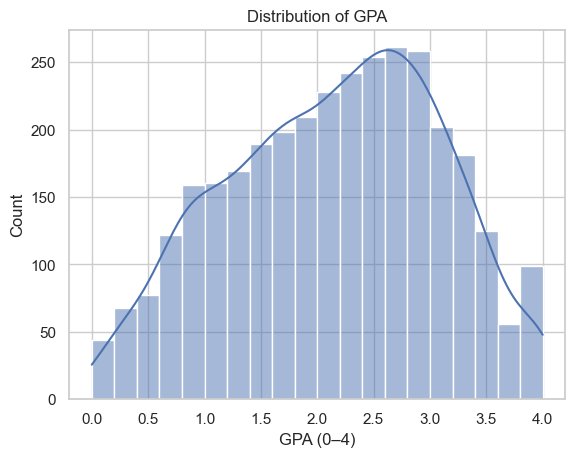

In [193]:
# Histogram: GPA
sns.histplot(combined_df["GPA"], kde=True, bins=20)
plt.title("Distribution of GPA")
plt.xlabel("GPA (0–4)")
plt.ylabel("Count")

plt.show()


###  Weekly Study Time Distribution

Most students study around **10–15 hours per week**.  
After 20 hours, the number of students drops sharply.  
This shows a **right-skewed distribution**, but still gives us a good range to model from.


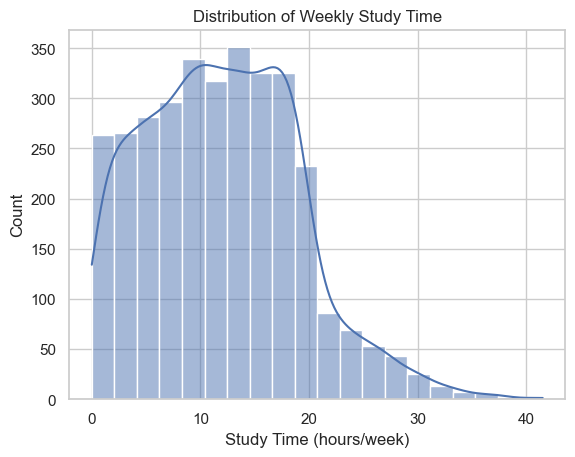

In [194]:
# Histogram: Study Time Weekly
sns.histplot(combined_df["StudyTimeWeekly"], kde=True, bins=20)
plt.title("Distribution of Weekly Study Time")
plt.xlabel("Study Time (hours/week)")
plt.ylabel("Count")

plt.show()


###  Study Time vs GPA

The scatter plot shows a **positive relationship**:  
Students who study more hours per week tend to have higher GPAs.  
However, the points are somewhat spread out — it’s not a perfect line.  
Still, this supports trying a **linear regression** model.


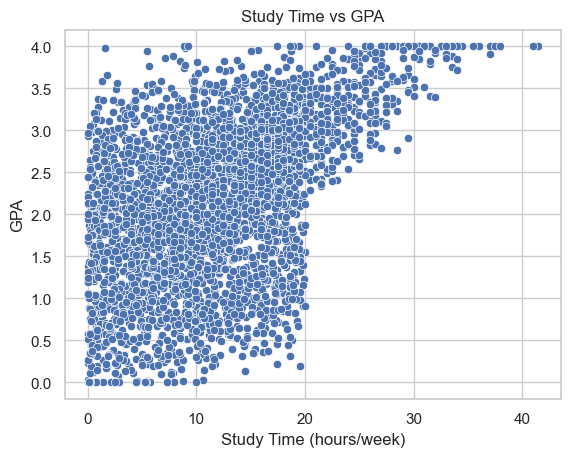

In [195]:
# Scatter plot: Study Time vs GPA
sns.scatterplot(x="StudyTimeWeekly", y="GPA", data=combined_df)
plt.title("Study Time vs GPA")
plt.xlabel("Study Time (hours/week)")
plt.ylabel("GPA")

plt.show()


### Step 5: Train/Test Split and Model Training

To evaluate how well our model performs, we split the dataset into two parts:

- **Training set** (70%) — used to teach the model  
- **Test set** (30%) — used to check how well the model performs on new, unseen data

This approach helps us avoid overfitting and gives a more realistic picture of the model’s predictive power.

To start with, we want to learn the model elationship between how much a student studies and the grade (GPA) they get.
 - X is the feature (input):
We're telling the model:
➜ "Use StudyTimeWeekly to make your prediction."

y is the target (output):
We're telling the model:
➜ "Try to predict the GPA.

In [196]:
# Define feature and target
X = combined_df[["StudyTimeWeekly"]]  # input
y = combined_df["GPA"]                # output

Next we spilt it into training and testing datasets. 

**Note**
we use "random_state=42" to split between training and test data that makes sure it done the same way everything it's run. 
42 is just a common choice that many developers use for fun. 

In [197]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

**After we create and train the model**

In [198]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

###  Step 6: Model Evaluation Results

To measure how well our model performs, we use two common evaluation metrics:

- **R² Score** (Explained Variance):
This tells us how much of the variation in GPA the model can explain.
A score of 1.0 means perfect prediction; 0.0 means the model is no better than guessing the average.

- **RMSE**  (Root Mean Squared Error):
This measures how far off the model’s predictions are, on average.
It’s in the same unit as the target (GPA), so it tells us the typical size of a prediction error.

These metrics help us understand both how well the model fits the data and how useful its predictions are.


In [199]:

# Predict GPA for the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print results
print(f"R² score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

R² score: 0.242
RMSE: 0.828


###  Model Performance Summary 
Now let’s look at the actual results for our model:

- **R² Score = 0.242**
The model explains about 24.2% of the variation in GPA.
This is a modest result — it shows some relationship between study time and GPA, but not a strong one.

- **RMSE = 0.828**
On average, the model’s predictions are off by 0.83 GPA points.
Since GPA ranges from 0 to 4, this is a moderate prediction error.

The chart below summarizes these values visually, helping us quickly compare model accuracy vs. error.

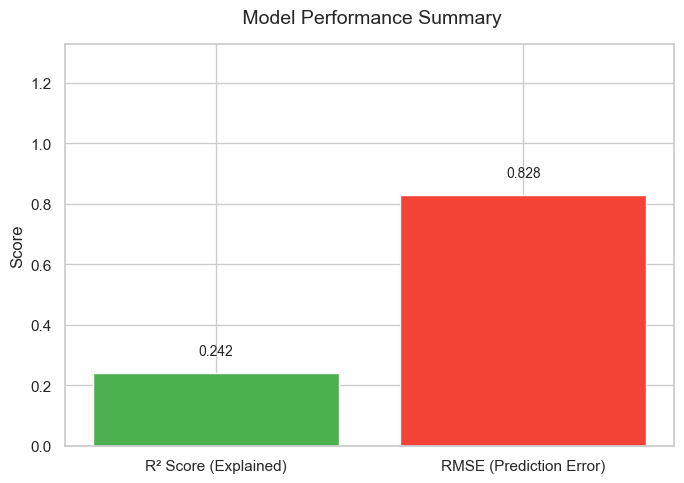

In [200]:

# Raw metric values (not converted to %)
labels = ['R² Score (Explained)', 'RMSE (Prediction Error)']
values = [r2, rmse]
colors = ['#4CAF50', '#F44336']  # green for right, red for error

# Create bar plot
plt.figure(figsize=(7, 5))
bars = plt.bar(labels, values, color=colors)

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f"{height:.3f}", ha='center', va='bottom', fontsize=10)

# Chart title and styling
plt.title(" Model Performance Summary", fontsize=14, pad=15)
plt.ylabel("Score")
plt.ylim(0, max(values) + 0.5)
plt.tight_layout()
plt.show()


#  Mini Conclusion: GPA Prediction Model

In this project, we built and evaluated a simple linear regression model to predict a student's GPA based on their weekly study time.


####  What went well:
- We successfully cleaned and combined two different datasets (real + simulated)
- We found a clear trend: students who study more tend to get higher GPAs
- The model was easy to build, explain, and served as a strong first attempt

####  What could be improved:
- The model didn’t predict GPA very accurately
- It only explained about 24% of the variation in GPA (R² = 0.242)
- We only used one variable (study time), which is too simple to explain something as complex as academic performance

####  Research Question:
**Can we predict a student’s likely grade using a machine learning model based only on weekly study time?**

#  Answer:
Even though the model worked to a degree (24% explained), the answer is **no** —  
we can’t accurately predict a student’s GPA using just one habit like study time.

To build a better model, we would need to include more factors such as sleep, absences, mental health, and parental education.


This gave us a good baseline. The next step is to make the model smarter with more data.


##  Just for Fun: Can We Make the Model Better?

Our original goal was simple:  
**Can we predict a student’s GPA using only their weekly study time?**

We tried — but the model only explained about **24% of the variation** in GPA.  
That’s not great… so now we’re just having fun and seeing if we can do better.

This time, we’ll add a bit more useful info:
- **Absences** – skipping class might hurt performance  
- **Parental Education** – students with more educated parents may do better  

Let’s see if this helps the model get smarter.  
Since this is just for fun, we’ll skip all the step-by-step explanation and do it all in one go!

In [201]:

sim_df.rename(columns={"parental_education_level": "ParentalEducation"}, inplace=True)
np.random.seed(42)
sim_df["Absences"] = np.random.randint(0, 15, size=len(sim_df))
sim_df["GPA"] = (sim_df["exam_score"] / 100) * 4

real_model_df = real_df[["StudyTimeWeekly", "ParentalEducation", "Absences", "GPA"]]
sim_model_df = sim_df[["StudyTimeWeekly", "ParentalEducation", "Absences", "GPA"]]

combined_df = pd.concat([real_model_df, sim_model_df], ignore_index=True)
combined_df.dropna(inplace=True)

combined_df = combined_df[combined_df["ParentalEducation"].apply(lambda x: isinstance(x, str))]
encoder = LabelEncoder()
combined_df["ParentalEducation"] = encoder.fit_transform(combined_df["ParentalEducation"])


X = combined_df[["StudyTimeWeekly", "ParentalEducation", "Absences"]]
y = combined_df["GPA"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f" R² score (forklaret variation): {r2:.3f}")
print(f" RMSE (gennemsnitlig fejl): {rmse:.3f}")


 R² score (forklaret variation): 0.680
 RMSE (gennemsnitlig fejl): 0.379


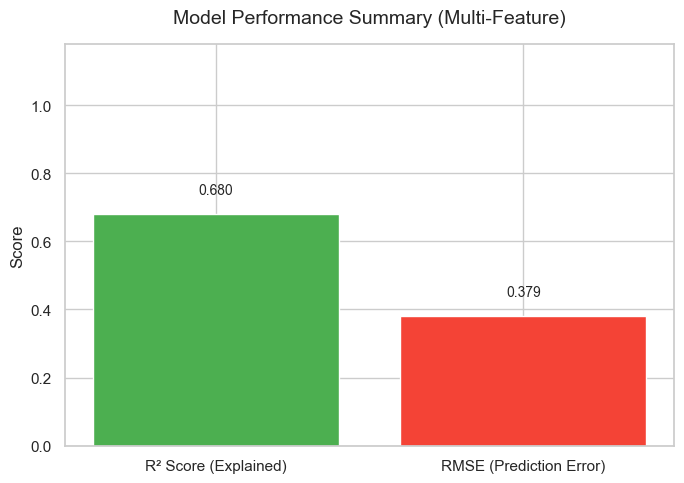

In [202]:
# 5.
labels = ['R² Score (Explained)', 'RMSE (Prediction Error)']
values = [r2, rmse]
colors = ['#4CAF50', '#F44336'] 

plt.figure(figsize=(7, 5))
bars = plt.bar(labels, values, color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f"{height:.3f}",
             ha='center', va='bottom', fontsize=10)

plt.title("Model Performance Summary (Multi-Feature)", fontsize=14, pad=15)
plt.ylabel("Score")
plt.ylim(0, max(values) + 0.5)
plt.tight_layout()
plt.show()



 ##  Model Improvement Summary

 Our first model used only **study time** and explained about **24%** of the GPA variation.
 By adding **Absences** and **Parental Education** as features, the model became noticeably better:

- **Higher R²** → It now captures more of what influences GPA  
- **Lower RMSE** → Predictions are closer to actual values

 **Conclusion**: More meaningful features = better predictions.  
 This shows that academic performance is affected by multiple factors — not just study habits.


#  Final Conclusion: Improving GPA Prediction with More Data

We began with a simple linear regression model using only weekly study time, which showed a clear positive trend but explained just **24%** of the variation in GPA. While this gave us a solid baseline, it also revealed the limits of using a single variable to predict something as complex as academic performance.

To improve the model, we added **Absences** and **Parental Education** — two realistic and relevant factors. This made the model more accurate, with:
- **Higher R²** (explained more variation)
- **Lower RMSE** (better prediction accuracy)

 **Key takeaway**: Academic success depends on more than just study habits. By including more meaningful features, we created a smarter, more reliable model — and proved that in machine learning, **more context leads to better predictions**.
